## OBJECTIVE : 
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

## Importing Libraries & getting Data

In [1]:
import numpy as np 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
import math 
import os 
import string 
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

# Metrics libraries
from sklearn.metrics import accuracy_score ,confusion_matrix, roc_curve, auc ,roc_auc_score

# NLP libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13571700751480412904
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1753127323
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5139375257721126381
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
connection = sqlite3.connect(
    'G:/My Drive/datasets/amazon food review/dataset/database.sqlite')

# ignoring datapoints where score = 3 (neutral review)

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
LIMIT 100000
""", connection)

In [5]:
# label encoding score into positive (x>3) and negative (x<3)

def partition(x):
    if x < 3:
        return 0
    else:
        return 1


score_with_neutral = filtered_data['Score']
score_wo_neutral = score_with_neutral.map(partition)

filtered_data['Score'] = score_wo_neutral

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             100000 non-null  object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 100000 non-null  object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [8]:
filtered_data.shape

(100000, 10)

In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId ,ProfileName ,Time, Score ,Text ,COUNT(*)
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""", connection)

In [10]:
display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [11]:
display.shape

(80668, 7)

In [12]:
display['COUNT(*)'].sum()

393063

# EDA

## Data Cleaning (Remove Duplicates)

In [13]:
display = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 AND UserId='#oc-R11D9D7SHXIJB9'
ORDER BY ProductId
""", connection)

display.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


#### NOTE :
- It can be seen that same user has multiple reviews with same values for all the parameters.

- So, in order to get unbiased results, we need to remove the rows having same parameters.

- Steps to do so:
    - first sort the data according to ProductId in ascending order.
    - Then just keep the first similar product review and delete the others.


In [14]:
sorted_data = filtered_data.sort_values(
    'ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
clean_data = sorted_data.drop_duplicates(
    subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)

clean_data.shape

(87775, 10)

# Data Preprocessing

#### Steps :

1. Begin by removing the HTML tags

2. Remove any punctuations or limited set of special characters like, or . etc

3. Check if the word is made up of english letters and is not alpha-numeric.

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the words to lowercase

6. Remove Stopwords

7. Stemming the word


In [16]:
# sample reviews

review_1 = clean_data['Text'].values[0]
print(review_1)
print('---------------------------------------')

review_2 = clean_data['Text'].values[1]
print(review_2)
print('---------------------------------------')

review_3 = clean_data['Text'].values[2]
print(review_3)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
---------------------------------------
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
---------------------------------------
I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attrac

### 1. Removing URLs

In [17]:
review_1 = re.sub('http\S+', "", review_1)
review_2 = re.sub('http\S+', "", review_2)
review_3 = re.sub('http\S+', "", review_3)

### 2. Removing HTML tags

In [18]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(review_1, 'lxml')
review_1 = soup.get_text()

soup = BeautifulSoup(review_2, 'lxml')
review_2 = soup.get_text()

soup = BeautifulSoup(review_3, 'lxml')
review_3 = soup.get_text()

### 3. Removing Apostrophes

In [19]:
def removing_apostrophes(text):
    # general
    text = re.sub("n\'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("\'s", " is", text)
    text = re.sub("\'d", " would", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("\'t", " not", text)
    text = re.sub("\'ve", " have", text)
    text = re.sub("\'m", " am", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("can\'t", "can not", text)

    return text

In [20]:
# isn't gets converted to 'is not' in line 3
review_3 = removing_apostrophes(review_3)
print(review_3)

I had an infestation of fruitflies, they were literally everywhere flying around me in my  kitchen, so I bought this product hoping to at least get rid of a few. But after 2 weeks, only 1 fly had stuck... I was going around with a notepad and squishing the buggers myself with a success rate of 2-3 a day so clearly this product was useless! I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass... but still it did nothing to get them stuck. And then I actually saw a second fly land on it once, and I watched as it flapped it is wings frantically and within 30 secs it had unstuck itself!!!! This product was a total waste of money!


### 4. Removing Numbers / Punctuations /Special Characters

In [21]:
# removing numbers
review_1 = re.sub('\S*\d\S*', "", review_1).strip()
print(review_1)
print('-----------------------------------------')

# removing special characters
review_3 = re.sub('[^A-Za-z0-9]+', ' ', review_3)
print(review_3)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
-----------------------------------------
I had an infestation of fruitflies they were literally everywhere flying around me in my kitchen so I bought this product hoping to at least get rid of a few But after 2 weeks only 1 fly had stuck I was going around with a notepad and squishing the buggers myself with a success rate of 2 3 a day so clearly this product was useless I even dabbed to red wine and banana to the top of the column after 1 week because they were really attracted to any red wine I had in a glass but still it did nothing to get them stuck And then I actually saw a second fly land on it once and I watched as it flapped it is wings frantically and within 30

### 5. Removing Stopwords

In [22]:
# removing the following words from the stop words list: 'no', 'nor', 'not'

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
                 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                 "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                 'won', "won't", 'wouldn', "wouldn't"])

### Combining all Steps

In [23]:
preprocessed_reviews = []

for text in tqdm(clean_data['Text'].values):
    text = re.sub('http\S+', "", text)
    text = BeautifulSoup(text, 'lxml').get_text()

    text = removing_apostrophes(text)

    text = re.sub('\S*\d\S*', "", text).strip()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    text = ' '.join(i.lower()
                    for i in text.split() if i.lower() not in stopwords)

    preprocessed_reviews.append(text.strip())

100%|██████████| 87775/87775 [00:24<00:00, 3657.14it/s]


## Splitting into train, test & validation sets

In [24]:
X = preprocessed_reviews
y = np.array(clean_data['Score'])

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Models

## 1. Bag of Words (BoW)

In [26]:
from sklearn.naive_bayes import MultinomialNB 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [27]:
vectorizer = CountVectorizer()

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
X_val_bow = vectorizer.transform(X_val)

### 1.1 Hyperparameter Tuning

In [28]:
alpha = [10**-5 ,10**-4 ,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2 ,10**3 ,10**4 ,10**5]

cv_scores = []

for i in alpha:
    bow_nb = MultinomialNB(alpha=i)

    scores = cross_val_score(bow_nb, X_train_bow, y_train,
                             cv=10, scoring='roc_auc', n_jobs=1,verbose=3)

    cv_scores.append(scores.mean())


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.813) total time=   0.0s
[CV] END ................................ score: (test=0.805) total time=   0.0s
[CV] END ................................ score: (test=0.802) total time=   0.0s
[CV] END ................................ score: (test=0.810) total time=   0.0s
[CV] END ................................ score: (test=0.788) total time=   0.0s
[CV] END ................................ score: (test=0.790) total time=   0.0s
[CV] END ................................ score: (test=0.799) total time=   0.0s
[CV] END ................................ score: (test=0.806) total time=   0.0s
[CV] END ................................ score: (test=0.782) total time=   0.0s
[CV] END ................................ score: (test=0.819) total time=   0.0s
[CV] END ................................ score: (test=0.835) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.825) total time=   0.0s
[CV] END ................................ score: (test=0.825) total time=   0.0s
[CV] END ................................ score: (test=0.833) total time=   0.0s
[CV] END ................................ score: (test=0.811) total time=   0.0s
[CV] END ................................ score: (test=0.813) total time=   0.0s
[CV] END ................................ score: (test=0.822) total time=   0.0s
[CV] END ................................ score: (test=0.826) total time=   0.0s
[CV] END ................................ score: (test=0.810) total time=   0.0s
[CV] END ................................ score: (test=0.843) total time=   0.0s
[CV] END ................................ score: (test=0.862) total time=   0.0s
[CV] END ................................ score: (test=0.850) total time=   0.0s
[CV] END ................................ score: (test=0.850) total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=   0.0s
[CV] END ................................ score: (test=0.884) total time=   0.0s
[CV] END ................................ score: (test=0.882) total time=   0.0s
[CV] END ................................ score: (test=0.876) total time=   0.0s
[CV] END ................................ score: (test=0.897) total time=   0.0s
[CV] END ................................ score: (test=0.909) total time=   0.0s
[CV] END ................................ score: (test=0.902) total time=   0.0s
[CV] END ................................ score: (test=0.897) total time=   0.0s
[CV] END ................................ score: (test=0.907) total time=   0.0s
[CV] END ................................ score: (test=0.902) total time=   0.0s
[CV] END ................................ score: (test=0.891) total time=   0.0s
[CV] END ................................ score: (test=0.911) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.904) total time=   0.0s
[CV] END ................................ score: (test=0.905) total time=   0.0s
[CV] END ................................ score: (test=0.913) total time=   0.0s
[CV] END ................................ score: (test=0.907) total time=   0.0s
[CV] END ................................ score: (test=0.900) total time=   0.0s
[CV] END ................................ score: (test=0.894) total time=   0.0s
[CV] END ................................ score: (test=0.906) total time=   0.0s
[CV] END ................................ score: (test=0.899) total time=   0.0s
[CV] END ................................ score: (test=0.891) total time=   0.0s
[CV] END ................................ score: (test=0.907) total time=   0.0s
[CV] END ................................ score: (test=0.898) total time=   0.0s
[CV] END ................................ score: (test=0.902) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.910) total time=   0.0s
[CV] END ................................ score: (test=0.719) total time=   0.0s
[CV] END ................................ score: (test=0.701) total time=   0.0s
[CV] END ................................ score: (test=0.693) total time=   0.0s
[CV] END ................................ score: (test=0.713) total time=   0.0s
[CV] END ................................ score: (test=0.682) total time=   0.0s
[CV] END ................................ score: (test=0.684) total time=   0.0s
[CV] END ................................ score: (test=0.706) total time=   0.0s
[CV] END ................................ score: (test=0.718) total time=   0.0s
[CV] END ................................ score: (test=0.701) total time=   0.0s
[CV] END ................................ score: (test=0.708) total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.557) total time=   0.0s
[CV] END ................................ score: (test=0.551) total time=   0.0s
[CV] END ................................ score: (test=0.550) total time=   0.0s
[CV] END ................................ score: (test=0.558) total time=   0.0s
[CV] END ................................ score: (test=0.539) total time=   0.0s
[CV] END ................................ score: (test=0.527) total time=   0.0s
[CV] END ................................ score: (test=0.552) total time=   0.0s
[CV] END ................................ score: (test=0.552) total time=   0.0s
[CV] END ................................ score: (test=0.543) total time=   0.0s
[CV] END ................................ score: (test=0.549) total time=   0.0s
[CV] END ................................ score: (test=0.522) total time=   0.0s
[CV] END ................................ score: (test=0.520) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.511) total time=   0.0s
[CV] END ................................ score: (test=0.524) total time=   0.0s
[CV] END ................................ score: (test=0.507) total time=   0.0s
[CV] END ................................ score: (test=0.495) total time=   0.0s
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.522) total time=   0.0s
[CV] END ................................ score: (test=0.507) total time=   0.0s
[CV] END ................................ score: (test=0.520) total time=   0.0s
[CV] END ................................ score: (test=0.479) total time=   0.0s
[CV] END ................................ score: (test=0.482) total time=   0.0s
[CV] END ................................ score: (test=0.467) total time=   0.0s
[CV] END ................................ score: (test=0.486) total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


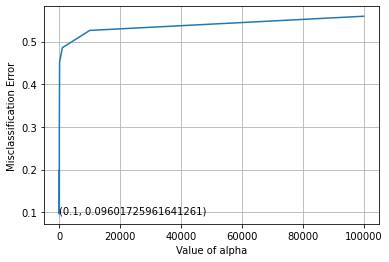

In [29]:
error = [1 - x for x in cv_scores]
optimal_value_of_alpha_bow = alpha[error.index(min(error))]

plt.plot(alpha, error)
xy = (optimal_value_of_alpha_bow, min(error))

plt.grid('True')
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Value of alpha')
plt.ylabel("Misclassification Error")
plt.show()

### 1.2 Model Building (BoW)

In [30]:
model_bow = MultinomialNB(alpha=optimal_value_of_alpha_bow)

model_bow.fit(X_train_bow, y_train)

# predicted values for train & test data
y_pred_bow = model_bow.predict_proba(X_train_bow)[:, 1]
y_pred_bow_test = model_bow.predict_proba(X_test_bow)[:, 1]

### 1.3 Model Evaluation (BoW)

In [31]:
print('Accuracy of BoW model : ',model_bow.score(X_test_bow, y_test))


Accuracy of BoW model :  0.9019481259256447


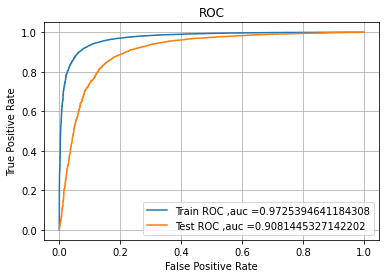

In [32]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_bow)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_bow_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_bow))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_bow_test))))

plt.title('ROC')
plt.grid('True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()


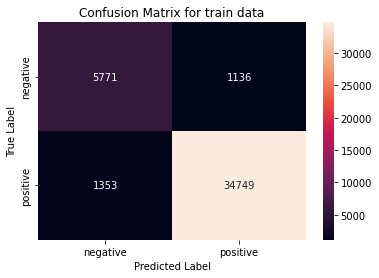

In [33]:
# confusion Matrix for train data
y_pred_bow = model_bow.predict(X_train_bow)

confusion = confusion_matrix(y_train, y_pred_bow)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


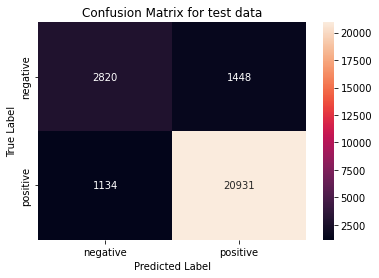

In [34]:
# confusion Matrix for test data
y_pred_bow_test = model_bow.predict(X_test_bow)

confusion = confusion_matrix(y_test, y_pred_bow_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 1.4 Feature Importance (BoW)

In [35]:
labels = ['negative' ,'positive']

def feature_importance(feature_names ,model):
    features = pd.DataFrame(data=model.feature_log_prob_.T ,index=feature_names ,columns=labels)

    positive = features.sort_values(by='positive' ,ascending=False)[0:10]
    negative = features.sort_values(by='negative' ,ascending=False)[0:10]

    return (positive ,negative)

In [36]:
positive_features ,negative_features = feature_importance(vectorizer.get_feature_names_out() ,model_bow)

In [37]:
# top 10 positive features 
positive_features

,negative,positive
not,-3.273780,-3.721051
like,-4.367713,-4.525767
good,-5.107377,-4.677263
great,-6.054929,-4.751916
one,-4.857640,-4.883274
taste,-4.685996,-4.971608
coffee,-5.132596,-5.028115
would,-4.649376,-5.047388
flavor,-5.186783,-5.075420
love,-5.993984,-5.095868


In [38]:
# top 10 negative features
negative_features

,negative,positive
not,-3.273780,-3.721051
like,-4.367713,-4.525767
would,-4.649376,-5.047388
taste,-4.685996,-4.971608
product,-4.716289,-5.121972
one,-4.857640,-4.883274
good,-5.107377,-4.677263
coffee,-5.132596,-5.028115
no,-5.185027,-5.366363
flavor,-5.186783,-5.075420


## 2. TFIDF

In [39]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=10)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)


### 2.1 Hyperparameter Tuning

In [40]:
alpha = [10**-5, 10**-4, 10**-3, 10**-2, 10**-
         1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

cv_scores = []

for i in alpha:
    tfidf_nb = MultinomialNB(alpha=i)

    scores = cross_val_score(tfidf_nb, X_train_bow, y_train,
                             cv=10, scoring='roc_auc', n_jobs=1, verbose=3)

    cv_scores.append(scores.mean())


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.813) total time=   0.0s
[CV] END ................................ score: (test=0.805) total time=   0.0s
[CV] END ................................ score: (test=0.802) total time=   0.0s
[CV] END ................................ score: (test=0.810) total time=   0.0s
[CV] END ................................ score: (test=0.788) total time=   0.0s
[CV] END ................................ score: (test=0.790) total time=   0.0s
[CV] END ................................ score: (test=0.799) total time=   0.0s
[CV] END ................................ score: (test=0.806) total time=   0.0s
[CV] END ................................ score: (test=0.782) total time=   0.0s
[CV] END ................................ score: (test=0.819) total time=   0.0s
[CV] END ................................ score: (test=0.835) total time=   0.0s
[CV] END ................................ score: (test=0.825) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.825) total time=   0.0s
[CV] END ................................ score: (test=0.833) total time=   0.0s
[CV] END ................................ score: (test=0.811) total time=   0.0s
[CV] END ................................ score: (test=0.813) total time=   0.0s
[CV] END ................................ score: (test=0.822) total time=   0.0s
[CV] END ................................ score: (test=0.826) total time=   0.0s
[CV] END ................................ score: (test=0.810) total time=   0.0s
[CV] END ................................ score: (test=0.843) total time=   0.0s
[CV] END ................................ score: (test=0.862) total time=   0.0s
[CV] END ................................ score: (test=0.850) total time=   0.0s
[CV] END ................................ score: (test=0.850) total time=   0.0s
[CV] END ................................ score: (test=0.858) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.839) total time=   0.0s
[CV] END ................................ score: (test=0.839) total time=   0.0s
[CV] END ................................ score: (test=0.852) total time=   0.0s
[CV] END ................................ score: (test=0.851) total time=   0.0s
[CV] END ................................ score: (test=0.840) total time=   0.0s
[CV] END ................................ score: (test=0.869) total time=   0.0s
[CV] END ................................ score: (test=0.886) total time=   0.0s
[CV] END ................................ score: (test=0.880) total time=   0.0s
[CV] END ................................ score: (test=0.875) total time=   0.0s
[CV] END ................................ score: (test=0.885) total time=   0.0s
[CV] END ................................ score: (test=0.873) total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=   0.0s
[CV] END ................................ score: (test=0.884) total time=   0.0s
[CV] END ................................ score: (test=0.882) total time=   0.0s
[CV] END ................................ score: (test=0.876) total time=   0.0s
[CV] END ................................ score: (test=0.897) total time=   0.0s
[CV] END ................................ score: (test=0.909) total time=   0.0s
[CV] END ................................ score: (test=0.902) total time=   0.0s
[CV] END ................................ score: (test=0.897) total time=   0.0s
[CV] END ................................ score: (test=0.907) total time=   0.0s
[CV] END ................................ score: (test=0.902) total time=   0.0s
[CV] END ................................ score: (test=0.891) total time=   0.0s
[CV] END ................................ score: (test=0.911) total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.902) total time=   0.0s
[CV] END ................................ score: (test=0.910) total time=   0.0s
[CV] END ................................ score: (test=0.719) total time=   0.0s
[CV] END ................................ score: (test=0.701) total time=   0.0s
[CV] END ................................ score: (test=0.693) total time=   0.0s
[CV] END ................................ score: (test=0.713) total time=   0.0s
[CV] END ................................ score: (test=0.682) total time=   0.0s
[CV] END ................................ score: (test=0.684) total time=   0.0s
[CV] END ................................ score: (test=0.706) total time=   0.0s
[CV] END ................................ score: (test=0.718) total time=   0.0s
[CV] END ................................ score: (test=0.701) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.708) total time=   0.0s
[CV] END ................................ score: (test=0.557) total time=   0.0s
[CV] END ................................ score: (test=0.551) total time=   0.0s
[CV] END ................................ score: (test=0.550) total time=   0.0s
[CV] END ................................ score: (test=0.558) total time=   0.0s
[CV] END ................................ score: (test=0.539) total time=   0.0s
[CV] END ................................ score: (test=0.527) total time=   0.0s
[CV] END ................................ score: (test=0.552) total time=   0.0s
[CV] END ................................ score: (test=0.552) total time=   0.0s
[CV] END ................................ score: (test=0.543) total time=   0.0s
[CV] END ................................ score: (test=0.549) total time=   0.0s
[CV] END ................................ score: (test=0.522) total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.520) total time=   0.0s
[CV] END ................................ score: (test=0.511) total time=   0.0s
[CV] END ................................ score: (test=0.524) total time=   0.0s
[CV] END ................................ score: (test=0.507) total time=   0.0s
[CV] END ................................ score: (test=0.495) total time=   0.0s
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.522) total time=   0.0s
[CV] END ................................ score: (test=0.507) total time=   0.0s
[CV] END ................................ score: (test=0.520) total time=   0.0s
[CV] END ................................ score: (test=0.479) total time=   0.0s
[CV] END ................................ score: (test=0.482) total time=   0.0s
[CV] END ................................ score: (test=0.467) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.486) total time=   0.0s
[CV] END ................................ score: (test=0.471) total time=   0.0s
[CV] END ................................ score: (test=0.458) total time=   0.0s
[CV] END ................................ score: (test=0.465) total time=   0.0s
[CV] END ................................ score: (test=0.482) total time=   0.0s
[CV] END ................................ score: (test=0.467) total time=   0.0s
[CV] END ................................ score: (test=0.479) total time=   0.0s
[CV] END ................................ score: (test=0.443) total time=   0.0s
[CV] END ................................ score: (test=0.450) total time=   0.0s
[CV] END ................................ score: (test=0.433) total time=   0.0s
[CV] END ................................ score: (test=0.450) total time=   0.0s
[CV] END ................................ score: (test=0.443) total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


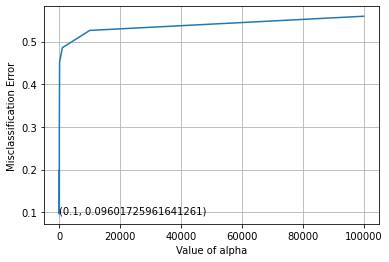

In [41]:
error = [1 - x for x in cv_scores]
optimal_value_of_alpha_tfidf = alpha[error.index(min(error))]

plt.plot(alpha, error)
xy = (optimal_value_of_alpha_tfidf, min(error))

plt.grid('True')
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Value of alpha')
plt.ylabel("Misclassification Error")
plt.show()


### 2.2 Model Building (TFIDF)

In [42]:
model_tfidf = MultinomialNB(alpha=optimal_value_of_alpha_tfidf)

model_tfidf.fit(X_train_tfidf, y_train)

# predicted values for train & test data
y_pred_tfidf = model_tfidf.predict_proba(X_train_tfidf)[:, 1]
y_pred_tfidf_test = model_tfidf.predict_proba(X_test_tfidf)[:, 1]

### 2.3 Model Evaluation (TFIDF)

In [43]:
print('Accuracy of TFIDF model : ',model_tfidf.score(X_test_tfidf, y_test))

Accuracy of TFIDF model :  0.90320130634565


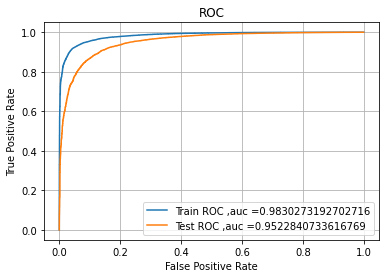

In [44]:
# plotting ROC curve for train & test data

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_pred_tfidf)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_tfidf_test)

fig = plt.figure()
ax = plt.subplot(111)

# train ROC
ax.plot(false_positive_rate1, true_positive_rate1, label='Train ROC ,auc ={}'.format(str(roc_auc_score(y_train, y_pred_tfidf))))

# test ROC
ax.plot(false_positive_rate2, true_positive_rate2, label='Test ROC ,auc ={}'.format(str(roc_auc_score(y_test, y_pred_tfidf_test))))

plt.title('ROC')
plt.grid('True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend()
plt.show()


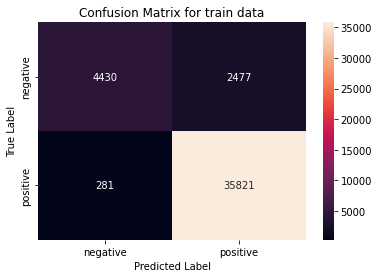

In [45]:
# confusion Matrix for train data
y_pred_tfidf = model_tfidf.predict(X_train_tfidf)

confusion = confusion_matrix(y_train, y_pred_tfidf)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


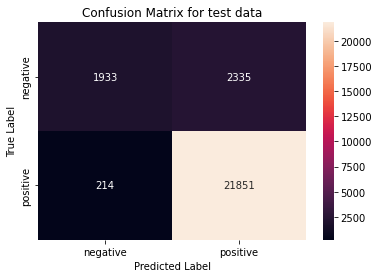

In [46]:
# confusion Matrix for test data
y_pred_tfidf_test = model_tfidf.predict(X_test_tfidf)

confusion = confusion_matrix(y_test, y_pred_tfidf_test)
class_labels = ["negative", "positive"]

cf_data = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
sns.heatmap(cf_data, annot=True, fmt='.5g')

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2.4 Feature Importance (TFIDF)

In [47]:
positive_features, negative_features = feature_importance(tfidf.get_feature_names_out(), model_tfidf)

In [48]:
# top 10 positive features
positive_features

,negative,positive
not,-4.705348,-5.238684
great,-7.053186,-5.589207
good,-6.168541,-5.665013
like,-5.497589,-5.698440
coffee,-5.905528,-5.760494
love,-6.882647,-5.834034
tea,-6.217120,-5.842444
one,-5.926656,-5.939072
taste,-5.650872,-5.949261
product,-5.637888,-5.958877


In [49]:
# top 10 negative features
negative_features

,negative,positive
not,-4.705348,-5.238684
like,-5.497589,-5.698440
product,-5.637888,-5.958877
taste,-5.650872,-5.949261
would,-5.664927,-6.104286
coffee,-5.905528,-5.760494
one,-5.926656,-5.939072
no,-6.094332,-6.290920
flavor,-6.102807,-5.978269
good,-6.168541,-5.665013


# Model Comparision

### Creating a prettytable to see which model performed better

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Vectorizer', 'Alpha', 'AUC']
x.add_row(["BOW", 0.1, 0.9081])
x.add_row(["TFIDF", 0.1, 0.9522])

x.sortby = 'AUC'
x.reversesort = True
print(x)


+------------+-------+--------+
| Vectorizer | Alpha |  AUC   |
+------------+-------+--------+
|   TFIDF    |  0.1  | 0.9522 |
|    BOW     |  0.1  | 0.9081 |
+------------+-------+--------+
